<a href="https://colab.research.google.com/github/Tanay2601/Signature-verification/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the necessary Library
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from pathlib import Path

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not use_cuda:
    print('No GPU found. Please use a GPU to train your neural network.')

In [ ]:
class SignaturesNetwork(nn.Module):
    def __init__(self):
        super(SignaturesNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
        nn.Conv2d(1, 96, kernel_size=11,stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),

        nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
        # First Dense Layer
        nn.Linear(30976, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
        # Second Dense Layer
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
        # Final Dense Layer
        nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        # returning the feature vectors of two inputs
        return output1, output2

In [ ]:
"""
https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
"""
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, label):
        # Find the pairwise distance or eucledian distance of two output feature vectors
        euclidean_distance = F.pairwise_distance(output1, output2)
        # perform contrastive loss calculation with the distance
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [ ]:
from PIL import ImageEnhance

class SignaturesDataset():

    def __init__(self, train, genuine_path, training_dir=None, transform=None, enhance_factor=4.5):
        # used to prepare the labels and images path
        self.training_df = train
        self.columns = ["file","signed_file","status"]
        self.training_dir = training_dir
        self.transform = transform
        self.genuine_path = genuine_path
        self.enhance_factor = enhance_factor

    def _enhance(self, image):
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(self.enhance_factor)

    def __getitem__(self,index):

        # getting the image path
        original_path=os.path.join(
            self.genuine_path,
            self.training_df.iat[index, 0])

        compare_path=os.path.join(
            self.training_dir,
            self.training_df.iat[index, 1])

        target = torch.from_numpy(
            np.array([int(self.training_df.iat[index, 2])],dtype=np.float32))

        # Loading the image
        original_img = self._enhance(Image.open(original_path))
        compare_img = self._enhance(Image.open(compare_path))

        original_img = original_img.convert("L")
        compare_img = compare_img.convert("L")

        #original_img = np.array(original_img)
        #compare_img = np.array(compare_img)

        data_transform = transforms.Compose([#transforms.ToPILImage(),
                                            transforms.Resize((105,105), Image.ANTIALIAS),
                                            #transforms.Grayscale(1),
                                            #transforms.RandomResizedCrop(224),
                                            #transforms.RandomHorizontalFlip(),
                                            #transforms.RandomVerticalFlip(),
                                            #transforms.RandomRotation(degrees=40),
                                            transforms.ToTensor(),
                                            #transforms.Normalize(mean=[0.456], std=[0.224])
                                            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])

        test_transform = transforms.Compose([#transforms.ToPILImage(),
                                            transforms.Resize((105,105), Image.ANTIALIAS),
                                            #transforms.Grayscale(1),
                                            #transforms.Resize(256),
                                            #transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            #transforms.Normalize(mean=[0.456], std=[0.224])
                                            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                            ])

        # Apply image transformations
        if self.transform == "train":
            original_img = data_transform(original_img)
            compare_img = data_transform(compare_img)
        else:
            original_img = test_transform(original_img)
            compare_img = test_transform(compare_img)

        return original_img, compare_img , target

    def __len__(self):
        return len(self.training_df)

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/signature-verification-dataset/sign_data/train_data.csv
/kaggle/input/signature-verification-dataset/sign_data/test_data.csv
/kaggle/input/signature-verification-dataset/sign_data/test/057/02_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/09_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/08_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/03_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/11_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/05_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/12_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/10_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/01_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/07_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/04_057.png
/kaggle/input/signature-verification

In [ ]:
genuine_path = Path('/kaggle/input/signature-verification-dataset/sign_data/sign_data/train')
forged_path = Path('/kaggle/input/signature-verification-dataset/sign_data/sign_data/test')
path = Path('/kaggle/input/signature-verification-dataset/sign_data/sign_data/')

train = pd.read_csv(path/"train_data.csv", low_memory=False)
test = pd.read_csv(path/"test_data.csv", low_memory=False)
display(train.head())

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [ ]:
# Load the the dataset from raw image folders

#an = SignaturesDataset(train, genuine_path)
#attrs = vars(an)
#print(attrs)

signatures_dataset = SignaturesDataset(train, genuine_path, training_dir=genuine_path, transform="train")
signatures_dataset_test = SignaturesDataset(test, forged_path, training_dir=forged_path, transform="test")

/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),


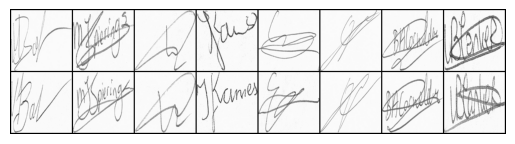

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(signatures_dataset,
                        shuffle=True,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
batch_size = 32
epochs = 40
learning_rate = 1e-4
alpha = 0.99
show_every_n_batches = 5

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(signatures_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

test_dataloader = DataLoader(signatures_dataset_test, num_workers=6, batch_size=1, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
# Declare Siamese Network
net = SignaturesNetwork()
#net = SiameseNetwork()

net.apply(init_weights)

if use_cuda:
    net = net.to('cuda')
    net = torch.nn.DataParallel(net)

# Decalre Loss Function
margin = 2
criterion = ContrastiveLoss(margin)
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, alpha=alpha, eps=1e-8, weight_decay=0.0005, momentum=0.9)
#optimizer = optim.Adam(net.parameters(),lr = learning_rate )

In [ ]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0
    original_loss = np.inf
    valid_loss = 0
    total_loss = 0

    for epoch in range(epochs):

        for i, (img0, img1 , label) in enumerate(train_dataloader):
            #img0, img1 , label = data
            img0, img1 , label = img0.to('cuda', non_blocking=True), img1.to('cuda', non_blocking=True) , label.to('cuda', non_blocking=True)

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            total_loss += loss_contrastive.item() * img0.size(0)
            #valid_corrects += torch.sum(preds == target.data)
            iteration_number += 1

        total_loss = total_loss/len(train_dataloader.dataset)

        if epoch%show_every_n_batches == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, total_loss, valid_loss))
            counter.append(iteration_number)
            loss_history.append(total_loss)
            if total_loss < original_loss:
                print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(original_loss,
                total_loss))
                with open('model.pt', 'wb') as pickle_file:
                    torch.save(net.state_dict(), pickle_file)
                original_loss = total_loss
            total_loss = 0
    show_plot(counter, loss_history)
    return net

/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 0 	Training Loss: 1.241351 	Validation Loss: 0.000000
Training loss decreased (inf --> 1.241351).  Saving model ...


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 5 	Training Loss: 1.227380 	Validation Loss: 0.000000
Training loss decreased (1.241351 --> 1.227380).  Saving model ...


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 10 	Training Loss: 1.199195 	Validation Loss: 0.000000
Training loss decreased (1.227380 --> 1.199195).  Saving model ...


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 15 	Training Loss: 1.236609 	Validation Loss: 0.000000


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 20 	Training Loss: 1.200966 	Validation Loss: 0.000000


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 25 	Training Loss: 1.212906 	Validation Loss: 0.000000


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 30 	Training Loss: 1.193178 	Validation Loss: 0.000000
Training loss decreased (1.199195 --> 1.193178).  Saving model ...


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Epoch: 35 	Training Loss: 1.189047 	Validation Loss: 0.000000
Training loss decreased (1.193178 --> 1.189047).  Saving model ...


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

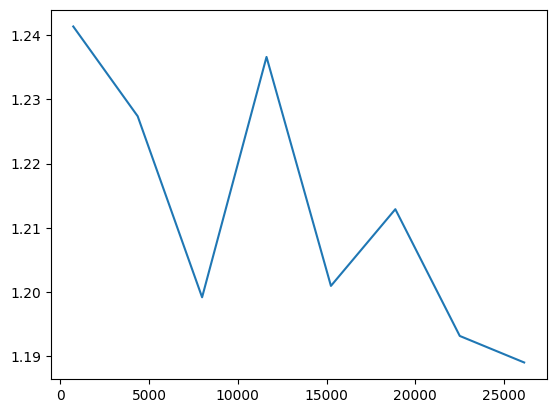

Model Saved Successfully


In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

In [ ]:
model = net
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [ ]:
accuracy=0
counter=0
correct=0

for i, data in enumerate(test_dataloader,0):

    x0, x1, label = data
    # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors

    output1, output2 = model(x0.to(device),x1.to(device))

    res = nn.Softmax(dim=1)(output1.cuda() - output2.cuda())
    label = label[0].tolist()
    label = int(label[0])
    result=torch.max(res,1)[1].data[0].tolist()
    if label == result:
        correct = correct+1
    counter=counter+1
    accuracy=(correct/len(test_dataloader))*100

print("Accuracy:{}%".format(accuracy))

/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

Accuracy:49.6780929180442%


/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((105,105), Image.ANTIALIAS),
/tmp/ipykernel_25/4089522272.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01

tensor([[0.3677, 0.6323]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


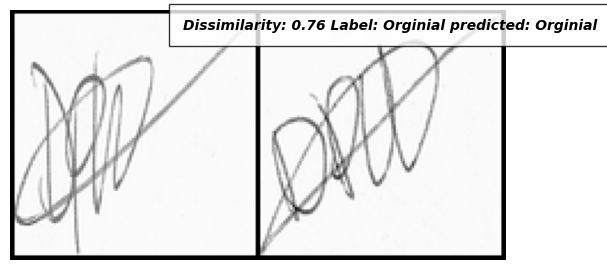

tensor([[0.3111, 0.6889]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


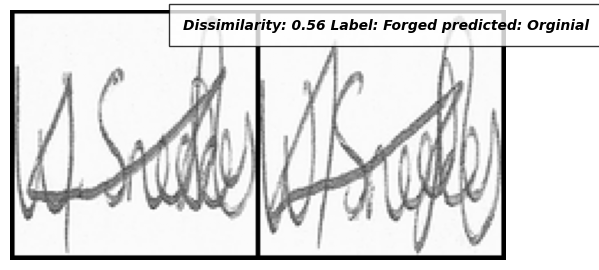

tensor([[0.3169, 0.6831]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


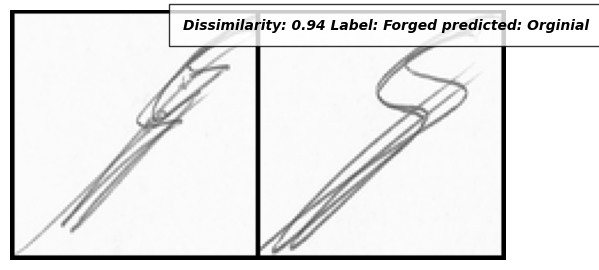

tensor([[0.5238, 0.4762]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


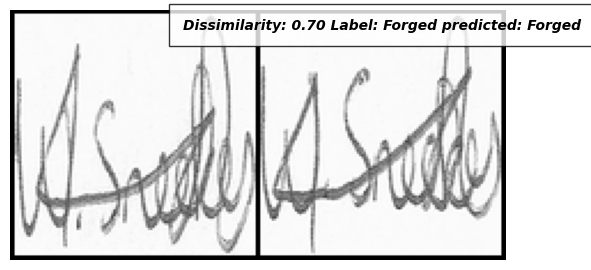

tensor([[0.4076, 0.5924]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


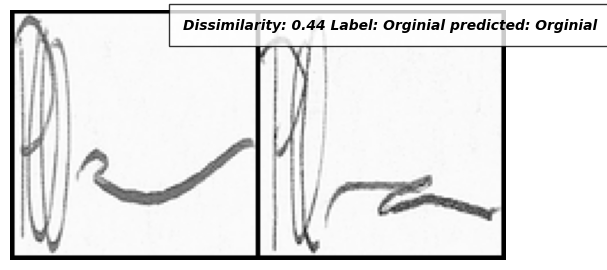

tensor([[0.4812, 0.5188]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


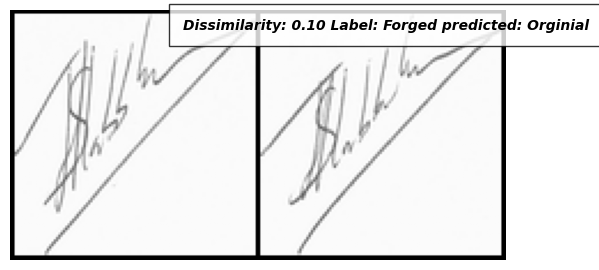

tensor([[0.3124, 0.6876]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


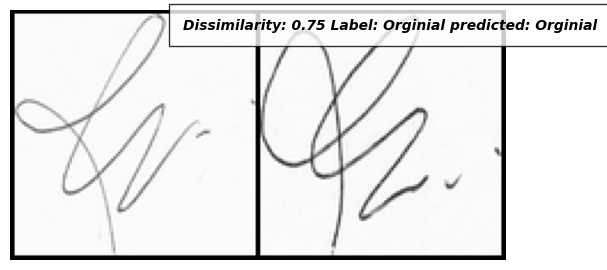

tensor([[0.8357, 0.1643]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


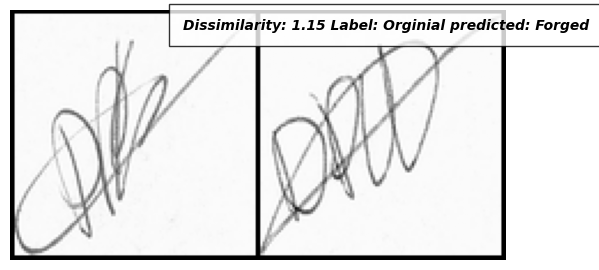

tensor([[0.5142, 0.4858]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


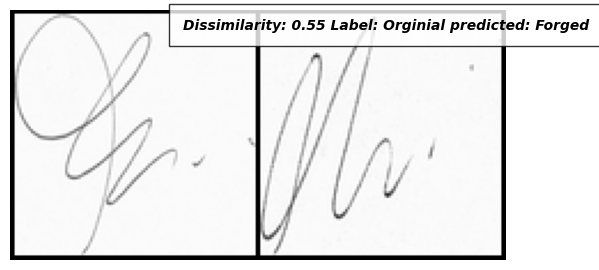

tensor([[0.7254, 0.2746]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


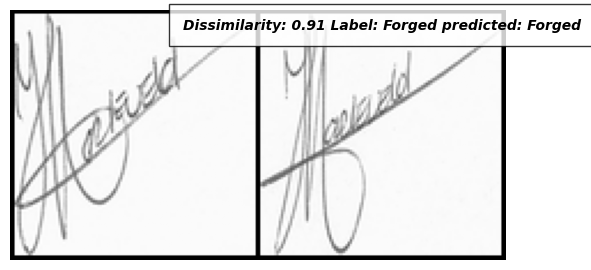

tensor([[0.2440, 0.7560]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


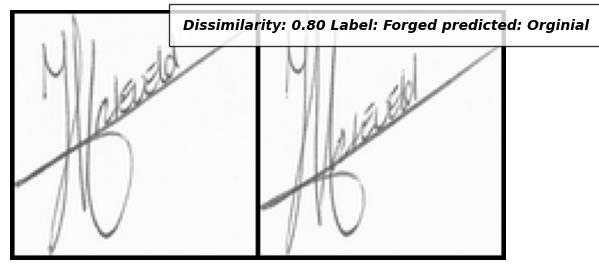

tensor([[0.3864, 0.6136]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


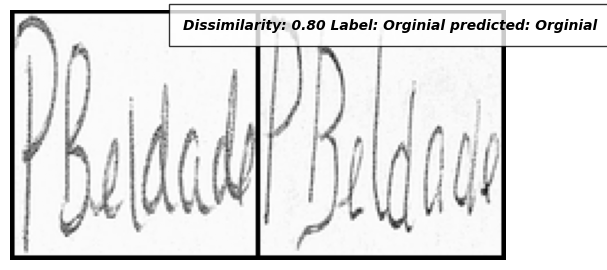

tensor([[0.6169, 0.3831]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


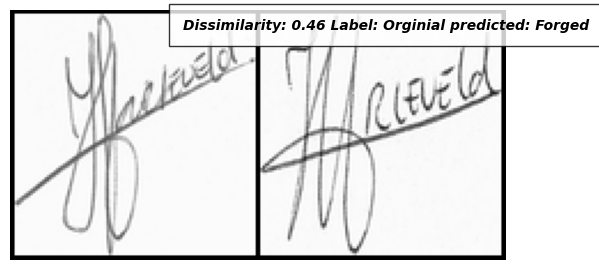

tensor([[0.5864, 0.4136]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


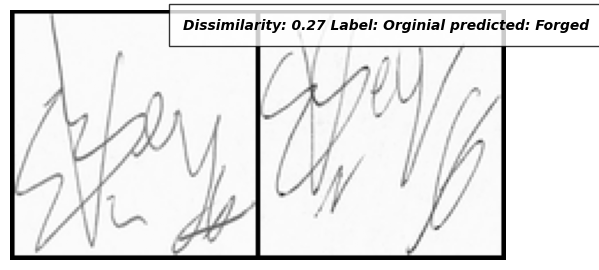

tensor([[0.3979, 0.6021]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


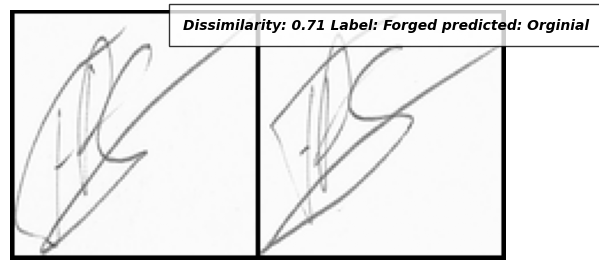

tensor([[0.2601, 0.7399]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


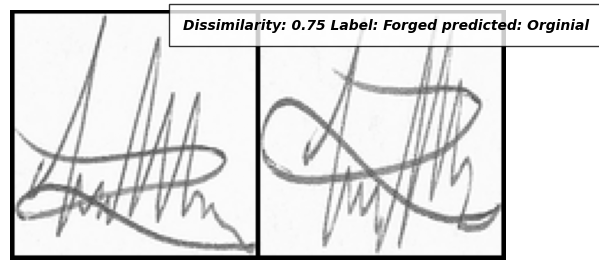

tensor([[0.1254, 0.8746]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


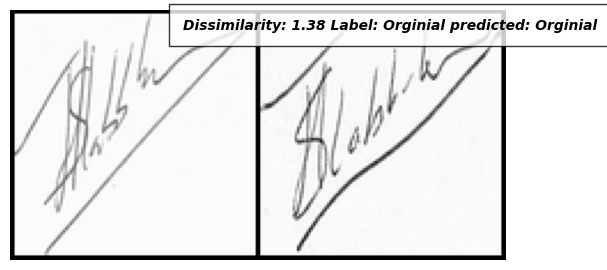

tensor([[0.3403, 0.6597]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


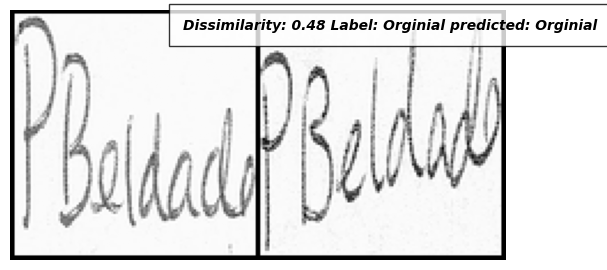

tensor([[0.4646, 0.5354]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


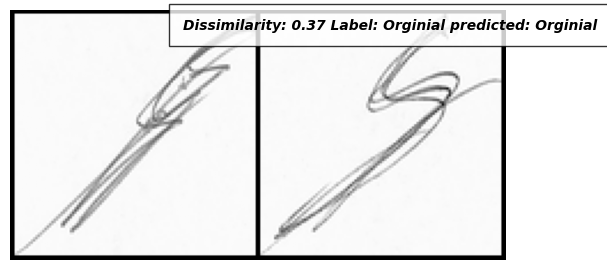

tensor([[0.3067, 0.6933]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


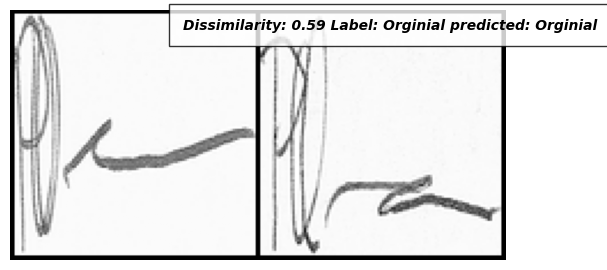

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_1 = torch.FloatTensor([[1]])
list_0 = torch.FloatTensor([[0]])

for i, data in enumerate(test_dataloader,0):
    x0, x1, label = data
    concatenated = torch.cat((x0,x1),0)
    output1, output2 = model(Variable(x0).to(device),Variable(x1).to(device))

    res = nn.Softmax(dim=1)(output1.cuda() - output2.cuda())
    eucledian_distance_1 = F.pairwise_distance(output2, output1)
    #eucledian_distance_2 = (output2 - output1).pow(2).sum(1)
    result=torch.max(res,1)[1].data[0].tolist()
    print(res)
    #print(eucledian_distance_1.item())
    #print(eucledian_distance_2)

    if result==1:
        pred_label="Orginial"
    else:
        pred_label="Forged"

    if label==list_1:
        label="Orginial"
    else:
        label="Forged"

    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {} predicted: {}'.format(eucledian_distance_1.item(),label, pred_label))
    counter = counter + 1
    if counter ==20:
        break